赛题二：重复购买

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import gc
from collections import Counter
import copy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

读取数据

In [2]:
test_data = pd.read_csv('./test_format1.csv')
train_data = pd.read_csv('./train_format1.csv')
user_info = pd.read_csv('./user_info_format1.csv')
user_log = pd.read_csv('./user_log_format1.csv')

In [3]:
train_data.head(3)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1


In [4]:
test_data.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [5]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [6]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [7]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [8]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


In [10]:
user_info.shape

(424170, 3)

查看缺失值-年龄缺失

In [11]:
(user_info.shape[0] - user_info['age_range'].count()) / user_info.shape[0]

np.float64(0.005226677982884221)

In [12]:
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count() # 年龄为空或者为0计数

user_id      95131
age_range    92914
gender       90664
dtype: int64

In [13]:
user_info.groupby(['age_range'])['user_id'].count() # 根据年龄分组对ID计数，查看每个年龄端人数

age_range
0.0     92914
1.0        24
2.0     52871
3.0    111654
4.0     79991
5.0     40777
6.0     35464
7.0      6992
8.0      1266
Name: user_id, dtype: int64

查看性别缺失

In [14]:
(user_info.shape[0] - user_info['gender'].count()) / user_info.shape[0]

np.float64(0.01517316170403376)

In [15]:
user_info[user_info['gender'].isna() | (user_info['gender'] == 2)].count() # 为空或者为2计数

user_id      16862
age_range    14664
gender       10426
dtype: int64

查看性别或年龄有一项为空

In [16]:
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0) | user_info['gender'].isna() | (user_info['gender'] == 2)].count() # 为空或者为2计数

user_id      106330
age_range    104113
gender        99894
dtype: int64

查看用户行为缺失值

In [17]:
user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

观察数据分布

In [18]:
user_info.describe()

,user_id,age_range,gender
count,424170.000000,421953.000000,417734.000000
mean,212085.500000,2.930262,0.341179
std,122447.476179,1.942978,0.524112
min,1.000000,0.000000,0.000000
25%,106043.250000,2.000000,0.000000
50%,212085.500000,3.000000,0.000000
75%,318127.750000,4.000000,1.000000
max,424170.000000,8.000000,2.000000


In [19]:
train_data.columns

Index(['user_id', 'merchant_id', 'label'], dtype='object')

正负样本分布情况，并可视化

In [20]:
label_gp = train_data.groupby('label')['user_id'].count()
print('正负样本的数量:\n',label_gp)

正负样本的数量:
 label
0    244912
1     15952
Name: user_id, dtype: int64


<Axes: xlabel='label', ylabel='count'>

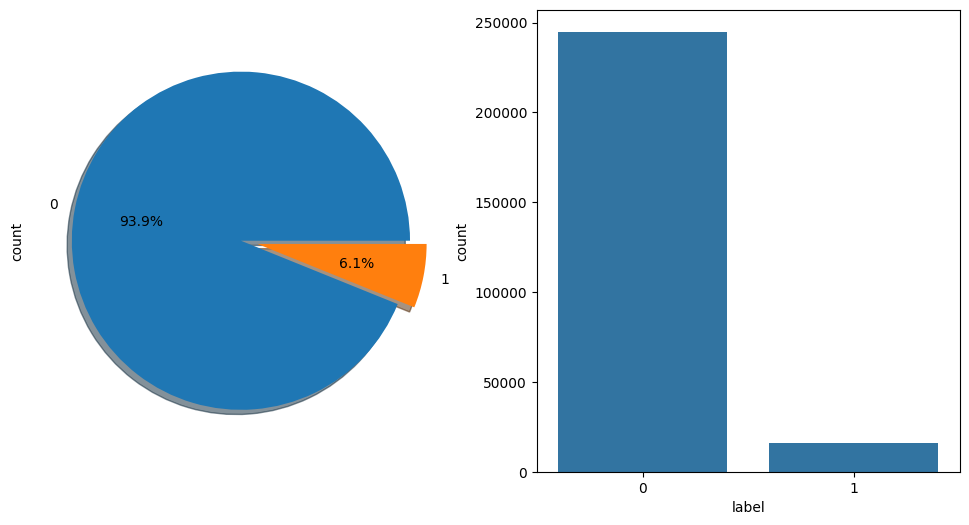

In [21]:
_, axe = plt.subplots(1, 2, figsize=(12,6))
train_data.label.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=[0, 0.1], ax=axe[0])
sns.countplot(x='label', data=train_data, ax=axe[1])

探查影响复购的因素-店铺

In [22]:
print('选取top5店铺\n店铺\t购买次数')
print(train_data.merchant_id.value_counts().head())

选取top5店铺
店铺	购买次数
merchant_id
4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: count, dtype: int64


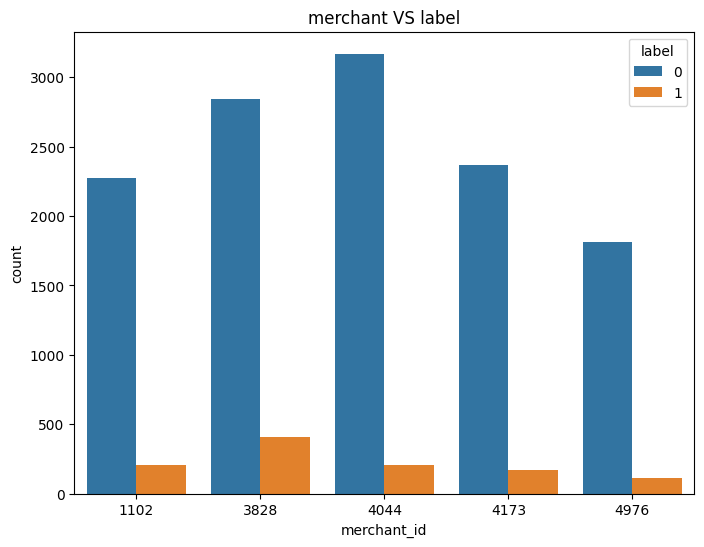

In [23]:
train_data_merchant = train_data.copy()
train_data_merchant['top5'] = train_data_merchant['merchant_id'].map(lambda x: 1 if x in [4044, 3828, 4173, 1102, 4976] else 0)
train_data_merchant = train_data_merchant[train_data_merchant['top5'] == 1]
plt.figure(figsize=(8,6))
plt.title('merchant VS label')
sax = sns.countplot(x='merchant_id', hue='label', data=train_data_merchant)

查看店铺的复购分布

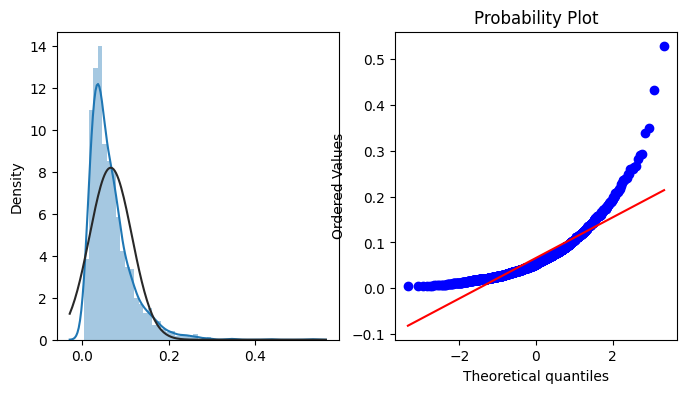

In [24]:
merchant_repeat_buy = [rate for rate in train_data.groupby(['merchant_id'])['label'].mean() if rate <= 1 and rate >0 ]
plt.figure(figsize=(8,4))

ax = plt.subplot(1, 2, 1)
sns.distplot(merchant_repeat_buy, fit=stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(merchant_repeat_buy, plot=plt)

用户进行分析，查看用户的复购分布

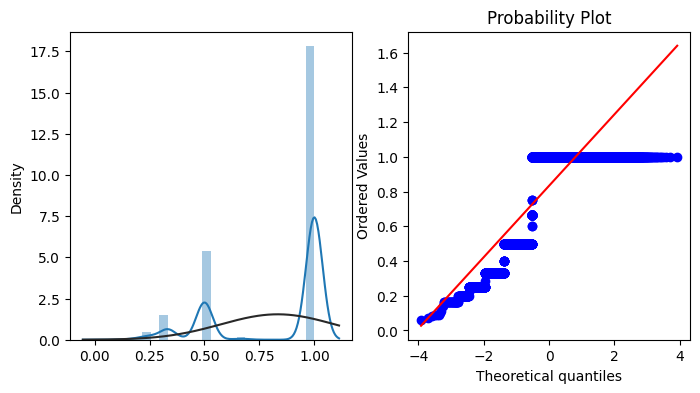

In [25]:
user_repeat_buy = [rate for rate in train_data.groupby(['user_id'])['label'].mean() if rate <= 1 and rate >0]
plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
sns.distplot(user_repeat_buy, fit=stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(user_repeat_buy, plot=plt)

对用户性别分析

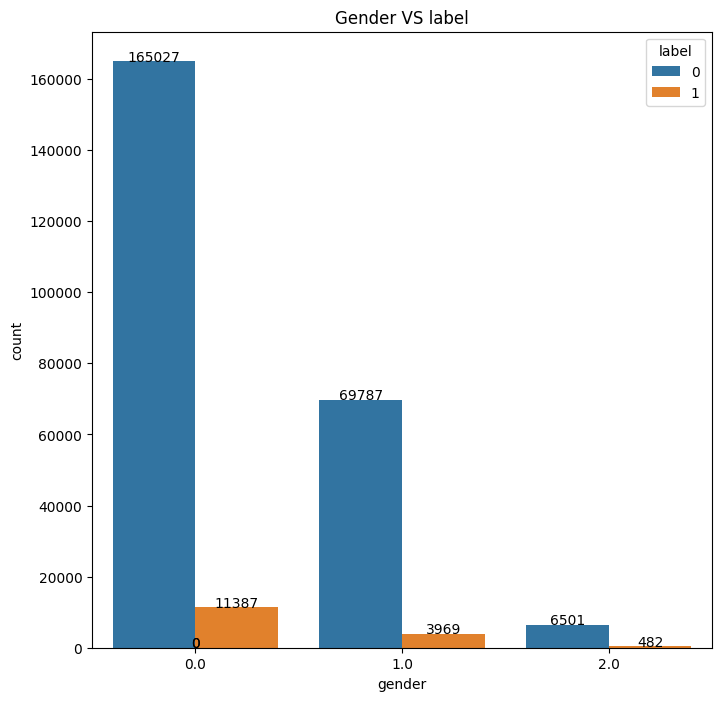

In [26]:
train_data_user_info = train_data.merge(user_info, on=['user_id'], how='left')

plt.figure(figsize=(8,8))
plt.title('Gender VS label')
ax = sns.countplot(x='gender', hue='label', data=train_data_user_info)
for p in ax.patches: # 每个柱形图上添加数据标签，获取每个柱形的高度（即对应的计数值）。后续代码通常会在柱形顶部添加这个数值
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 2, '{:1.0f}'.format(height), ha='center')

查看用户性别复购的分布

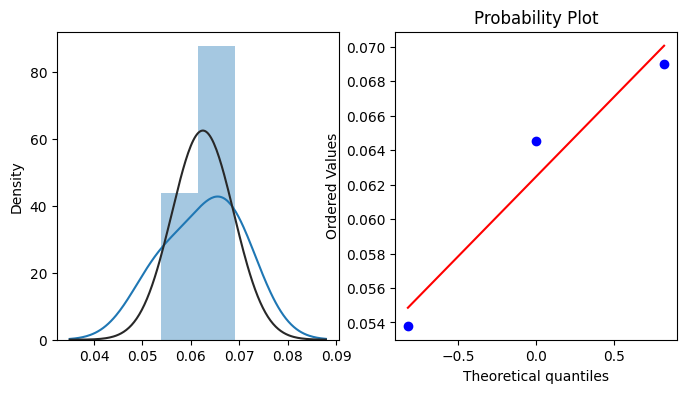

In [27]:
user_gender_repeat_buy = [rate for rate in train_data_user_info.groupby(['gender'])['label'].mean()]
plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
sns.distplot(user_gender_repeat_buy, fit=stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(user_gender_repeat_buy, plot=plt)

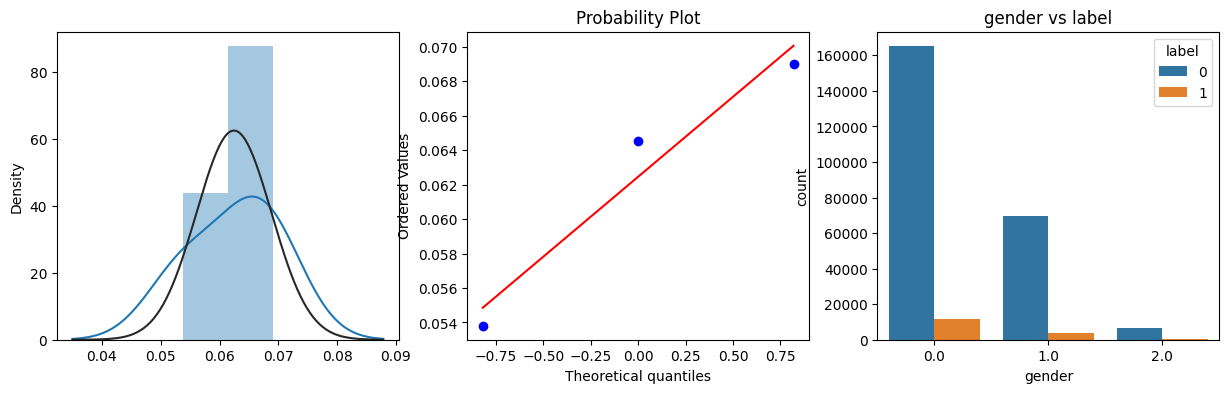

In [28]:
user_gender_repeat_buy = [rate for rate in train_data_user_info.groupby(['gender'])['label'].mean()]

plt.figure(figsize=(15,4))

ax = plt.subplot(1, 3, 1)
sns.distplot(user_gender_repeat_buy, fit=stats.norm)
ax = plt.subplot(1, 3, 2)
res = stats.probplot(user_gender_repeat_buy, plot=plt)
ax = plt.subplot(1, 3, 3)
plt.title('gender vs label')
ax = sns.countplot(x='gender', hue='label', data=train_data_user_info)

年龄与复购关系

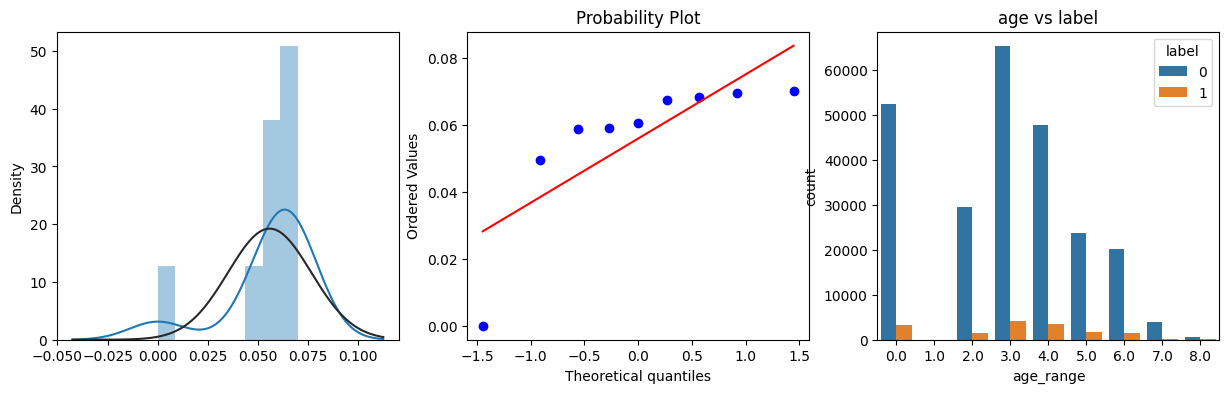

In [32]:
user_age_repeat_buy = [rate for rate in train_data_user_info.groupby(['age_range'])['label'].mean()]
plt.figure(figsize=(15,4))

ax = plt.subplot(1, 3, 1)
sns.distplot(user_age_repeat_buy, fit=stats.norm)
ax = plt.subplot(1, 3, 2)
res = stats.probplot(user_age_repeat_buy, plot=plt)
ax = plt.subplot(1, 3, 3)
plt.title('age vs label')
ax = sns.countplot(x='age_range', hue='label', data=train_data_user_info)

特征工程-
数据压缩

In [29]:
def reduce_mem_usage(df, verbose=True):
    """
    定义压缩方法
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(start_mem)
    numerices = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerices:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('memory usage after optimization is:', '{:.2f}MB'.format(end_mem))
    print('decreased by {:.1f}%'.format(100*(start_mem - end_mem)/start_mem))
    return df
                

In [30]:
# 对数据进行压缩
num_rows = None
train_data = reduce_mem_usage(train_data, num_rows)

5.970829010009766
memory usage after optimization is: 1.74MB
decreased by 70.8%


In [31]:
test_data = reduce_mem_usage(test_data, num_rows)

5.984859466552734
memory usage after optimization is: 3.49MB
decreased by 41.7%


In [32]:
user_log = reduce_mem_usage(user_log, num_rows)

2933.3292121887207
memory usage after optimization is: 890.48MB
decreased by 69.6%


In [33]:
user_info = reduce_mem_usage(user_info, num_rows)

9.708606719970703
memory usage after optimization is: 3.24MB
decreased by 66.7%


合并用户信息

In [34]:
all_data = train_data._append(test_data)
all_data = all_data.merge(user_info, on=['user_id'], how='left')
del train_data, test_data, user_info # 删除不要的表释放内存
gc.collect() # 强制垃圾回收

14284

In [35]:
"""
按时间排序
"""
user_log = user_log.sort_values(['user_id', 'time_stamp'])

对每个用户逐个合并所有字段，合并字段为item_id
cat_id,seller_id,brand_id,time_stamp,action_type

In [36]:
"""
合并数据
"""
list_join_func = lambda x: ' '.join([str(i) for i in x])

agg_dict = {
    'item_id': list_join_func,
    'cat_id': list_join_func,
    'seller_id': list_join_func,
    'brand_id': list_join_func,
    'time_stamp': list_join_func,
    'action_type': list_join_func
}

rename_dict = {
    'item_id': 'item_path',
    'cat_id': 'cat_path',
    'seller_id': 'seller_path',
    'brand_id': 'brand_path',
    'time_stamp': 'time_stamp_path',
    'action_type': 'action_type_path'
}

def merge_list(df_id, join_columns, df_data, agg_dict, rename_dict):
    df_data = df_data.groupby(join_columns).agg(agg_dict).reset_index().rename(columns=rename_dict)
    df_id = df_id.merge(df_data, on=join_columns, how='left')
    return df_id

all_data = merge_list(all_data, 'user_id', user_log, agg_dict, rename_dict)

In [37]:
del user_log
gc.collect()

0

定义数据统计函数
统计数据的总数

In [38]:
def cnt_(x):
    try:
        return len(x.split(' '))
    except:
        return -1

定义统计数据唯一值总数函数

In [39]:
def nunique_(x):
    try:
        return len(set(x.split(' '))) # 利用集合进行去重set
    except:
        return -1

定义统计数据最大值函数

In [40]:
def max_(x):
    try:
        return np.max([float(i) for i in x.split(' ')])
    except:
        return -1

定义统计数据最小值函数

In [41]:
def min_(x):
    try:
        return np.min([float(i) for i in x.split(' ')])
    except:
        return -1

定义统计数据标准差函数

In [42]:
def std_(x):
    try:
        return np.std([float(i) for i in x.split(' ')])
    except:
        return -1

定义统计数据TOP N数据函数

In [43]:
def most_n(x, n):
    try:
        return Counter(x.split(' ')).most_common(n)[n-1][0]
    except:
        return -1

定义统计数据TOP N数据总数函数

In [44]:
def most_n_cnt(x, n):
    try:
        return Counter(x.split(' ')).most_common(n)[n-1][1]
    except:
        return -1

调用定义的统计函数
调用数据集的特征统计函数

In [45]:
def user_cnt(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(cnt_)
    return df_data

In [46]:
def user_nunique(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(nunique_)
    return df_data

In [47]:
def user_max(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(max_)
    return df_data

In [48]:
def user_min(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(min_)
    return df_data

In [49]:
def user_std(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(std_)
    return df_data

In [50]:
def user_most_n(df_data, single_col, name, n=1):
    func = lambda x: most_n(x, n)
    df_data[name] = df_data[single_col].apply(func)
    return df_data

In [51]:
def user_most_n_cnt(df_data, single_col, name, n=1):
    func = lambda x: most_n_cnt(x, n)
    df_data[name] = df_data[single_col].apply(func)
    return df_data

提取特征

In [52]:
"""
提取基本统计特征
"""
all_data_test = all_data.head(2000)
# 统计用户点击，浏览，加购，购买行为
# 总次数
all_data_test = user_cnt(all_data_test, 'seller_path', 'user_cnt')
# 不同店铺个数
all_data_test = user_nunique(all_data_test, 'seller_path', 'seller_nunique')
# 不同品类个数
all_data_test = user_nunique(all_data_test, 'cat_path', 'cat_nunique')
# 不同品牌个数
all_data_test = user_nunique(all_data_test, 'brand_path', 'brand_nunique')
# 不同商品个数
all_data_test = user_nunique(all_data_test, 'item_path', 'item_nunique')
# 活跃天数
all_data_test = user_nunique(all_data_test, 'time_stamp_path', 'time_stamp_nunique')
# 不同用户行为种数
all_data_test = user_nunique(all_data_test, 'action_type_path', 'action_type_nunique')
# 最晚时间
all_data_test = user_max(all_data_test, 'action_type_path', 'time_stamp_max')
# 最早时间
all_data_test = user_min(all_data_test, 'action_type_path', 'time_stamp_min')
# 活跃天数方差
all_data_test = user_std(all_data_test, 'action_type_path', 'time_stamp_std')
# 最早和最晚时间相差天数
all_data_test['time_stamp_range'] = all_data_test['time_stamp_max'] - all_data_test['time_stamp_min']
# 用户最喜欢店铺
all_data_test = user_most_n(all_data_test, 'seller_path', 'seller_most_1', n=1)
# 最喜欢类目
all_data_test = user_most_n(all_data_test, 'cat_path', 'cat_most_1', n=1)
# 最喜欢品牌
all_data_test = user_most_n(all_data_test, 'brand_path', 'brand_most_1', n=1)
# 最常见的行为动作
all_data_test = user_most_n(all_data_test, 'action_type_path', 'action_type_1', n=1)
# 用户最喜欢的店铺，行为次数
all_data_test = user_most_n_cnt(all_data_test, 'seller_path', 'seller_most_1_cnt', n=1)
# 最喜欢的类目，行为次数
all_data_test = user_most_n_cnt(all_data_test, 'cat_path', 'cat_most_1_cnt', n=1)
# 最喜欢的品牌，行为次数
all_data_test = user_most_n_cnt(all_data_test, 'brand_path', 'brand_most_1_cnt', n=1)
# 最常见的行为动作，行为次数
all_data_test = user_most_n_cnt(all_data_test, 'action_type_path', 'action_type_1_cnt', n=1)

用户特征统计：对用户的点击，加购，购买，收藏等特征进行统计

In [56]:
# 对点击、加购、购买、收藏分开统计
def col_cnt_(df_data, columns_list, action_type):
    try:
        data_dict = {}
        col_list = copy.deepcopy(columns_list)
        if action_type != None:
            col_list += ['action_type_path']
        for col in col_list:
            data_dict[col] = df_data[col].split(' ')
        path_len = len(data_dict[col])
        data_out = []
        for i_ in range(path_len):
            data_txt = ''
            for col_ in columns_list:
                if data_dict['action_type_path'][i_] == action_type:
                    data_txt += data_dict[col_][i_]
            data_out.append(data_txt)
        return len(data_out)
    except:
        return -1

def col_nuique_(df_data, columns_list, action_type):
    try:
        data_dict = {}
        col_list = copy.deepcopy(columns_list)
        if action_type != None:
            col_list += ['action_type_path']
        for col in col_list:
            data_dict[col] = df_data[col].split(' ')
        path_len = len(data_dict[col])
        data_out = []
        for i_ in range(path_len):
            data_txt = ''
            for col_ in columns_list:
                if data_dict['action_type_path'][i_] == action_type:
                    data_txt += data_dict[col_][i_]
            data_out.append(data_txt)
        return len(set(data_out))
    except:
        return -1

def user_col_cnt(df_data,columns_list, action_type, name):
    df_data[name] = df_data.apply(lambda x: col_cnt_(x, columns_list, action_type), axis=1)
    return df_data

def user_col_nunique(df_data,columns_list, action_type, name):
    df_data[name] = df_data.apply(lambda x: col_nuique_(x, columns_list, action_type), axis=1)
    return df_data


统计用户和店铺的关系，对店铺的用户点击次数，加购次数，购买次数，收藏次数等进行统计

In [59]:
# 点击次数
# all_data_test = user_col_cnt(all_data_test, ['seller_path'], '0', 'user_cnt_0')
# 加购次数
# all_data_test = user_col_cnt(all_data_test, ['seller_path'], '1', 'user_cnt_1')
# all_data_test = user_col_cnt(all_data_test, ['seller_path'], '2', 'user_cnt_2')
# all_data_test = user_col_cnt(all_data_test, ['seller_path'], '3', 'user_cnt_3')

特征组合

In [63]:
# 点击次数
all_data_test = user_col_cnt(all_data_test, ['seller_path', 'item_path'], '0', 'user_cnt_0')
all_data_test = user_col_cnt(all_data_test, ['seller_path', 'item_path'], '1', 'user_cnt_1')
all_data_test = user_col_cnt(all_data_test, ['seller_path', 'item_path'], '2', 'user_cnt_2')
all_data_test = user_col_cnt(all_data_test, ['seller_path', 'item_path'], '3', 'user_cnt_3')
# 不同店铺数
all_data_test = user_col_nunique(all_data_test, ['seller_path', 'item_path'], '0', 'seller_nunique_0')


In [74]:
all_data_test.columns

Index(['user_id', 'merchant_id', 'label', 'prob', 'age_range', 'gender',
       'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path',
       'action_type_path', 'user_cnt', 'seller_nunique', 'cat_nunique',
       'brand_nunique', 'item_nunique', 'time_stamp_nunique',
       'action_type_nunique', 'time_stamp_max', 'time_stamp_min',
       'time_stamp_std', 'time_stamp_range', 'seller_most_1', 'cat_most_1',
       'brand_most_1', 'action_type_1', 'seller_most_1_cnt', 'cat_most_1_cnt',
       'brand_most_1_cnt', 'action_type_1_cnt', 'user_cnt_1', 'user_cnt_2',
       'user_cnt_3', 'user_cnt_0', 'seller_nunique_0'],
      dtype='object')